### Look at value trends by session, see if they associate with rules

In [1]:
import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
from constants.behavioral_constants import *
from constants.decoding_constants import *
from utils.session_data import SessionData
from matplotlib import pyplot as plt


In [2]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]
SMOOTH = 1
EVENT = "FeedbackOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"

In [5]:
session = 20180928
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)
# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh_merged = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
value_beh = behavioral_utils.get_feature_values_per_session(session, valid_beh_merged)
value_beh["TrialIdx"] = np.arange(len(value_beh))

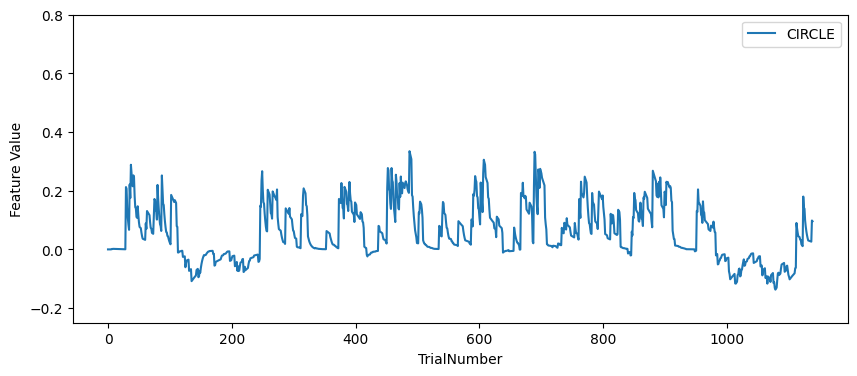

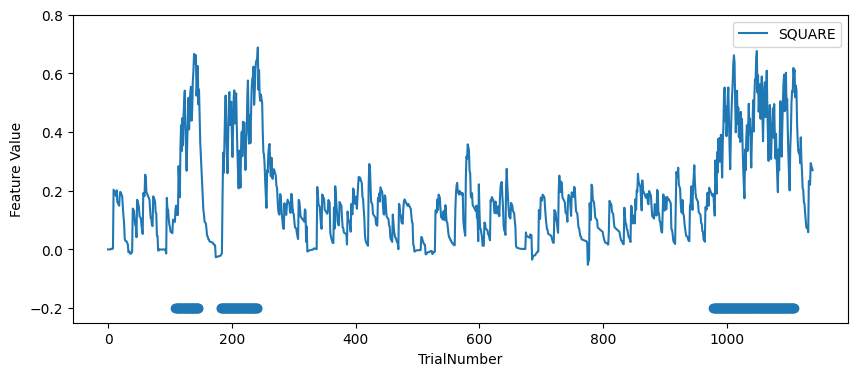

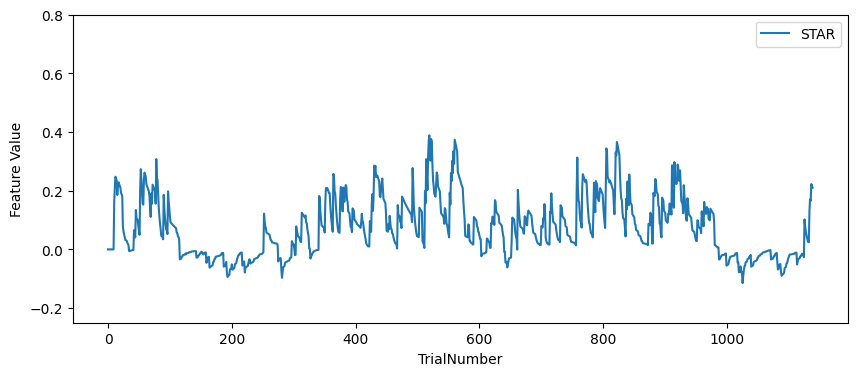

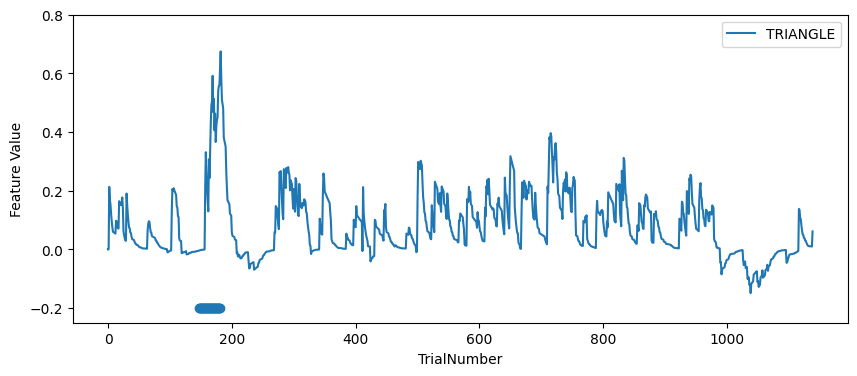

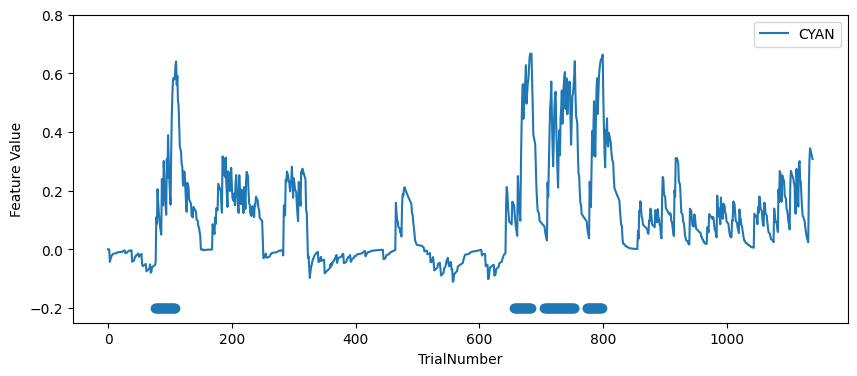

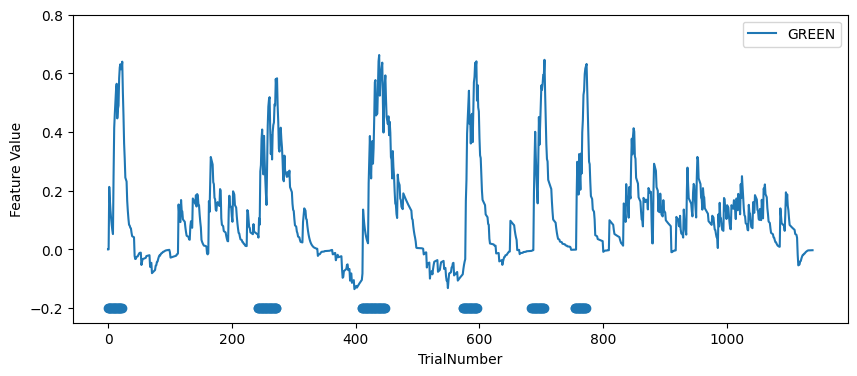

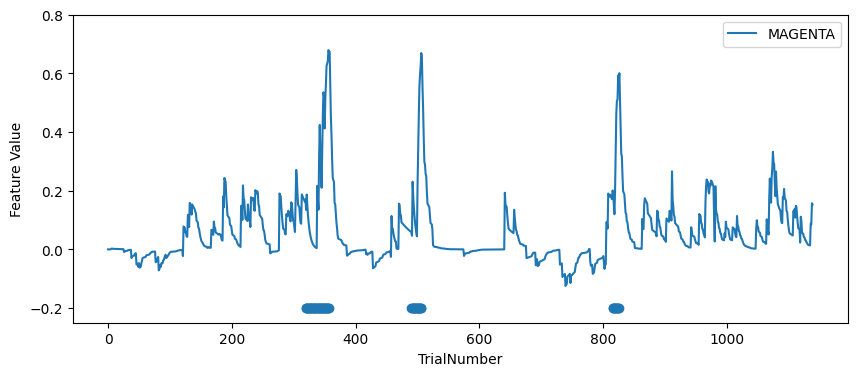

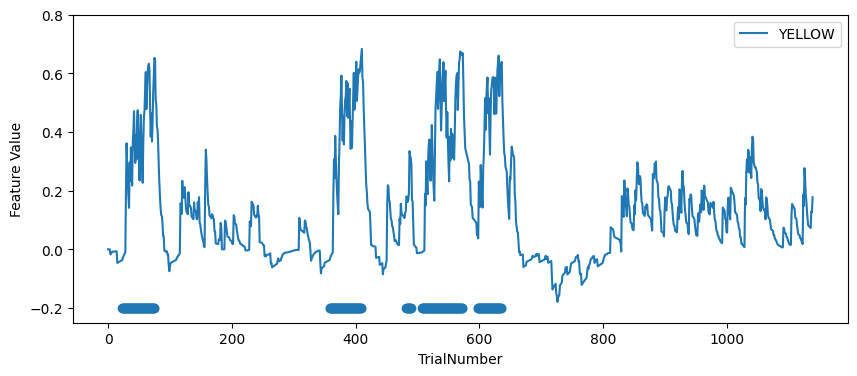

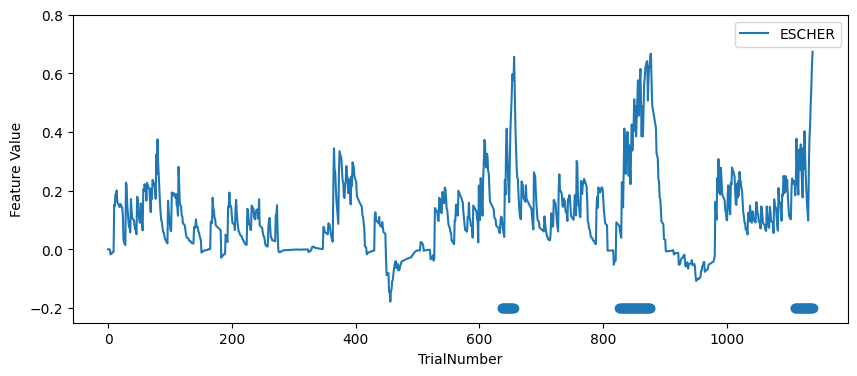

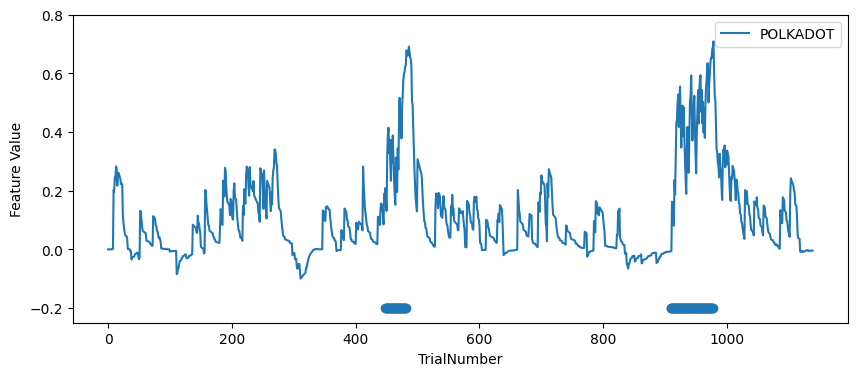

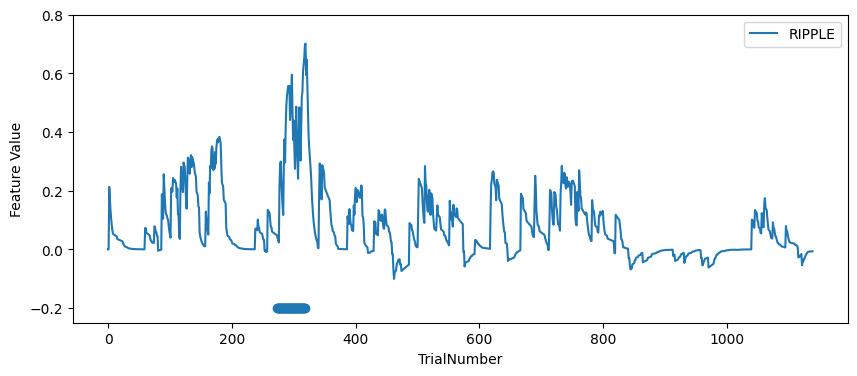

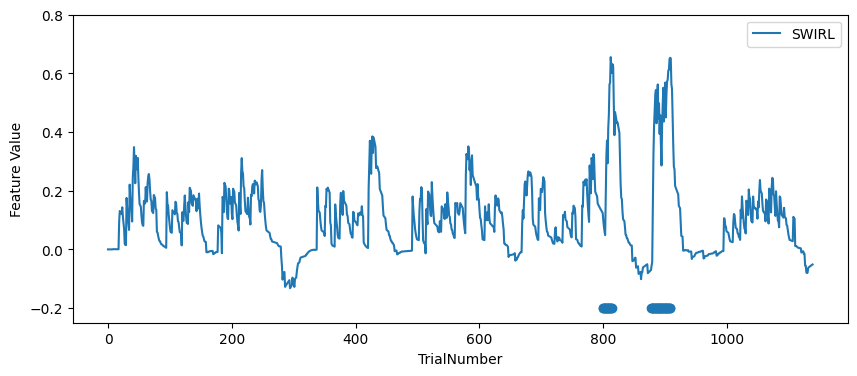

In [6]:
for feat in FEATURES:
    vals = value_beh[feat + "Value"]
    rule_trials = value_beh[value_beh.CurrentRule == feat].TrialIdx
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(vals, label=feat)
    ax.scatter(rule_trials, -0.2 * np.ones(len(rule_trials)))
    ax.set_ylim([-0.25, 0.8])
    ax.set_ylabel("Feature Value")
    ax.set_xlabel("TrialNumber")
    ax.legend()

### Ask: how does average block position relate to feature value? When feature is rule vs. not?

/src/wcst_decode/utils/behavioral_utils.py:443: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  beh = beh.groupby("BlockNumber").apply(get_block_lengths).reset_index()


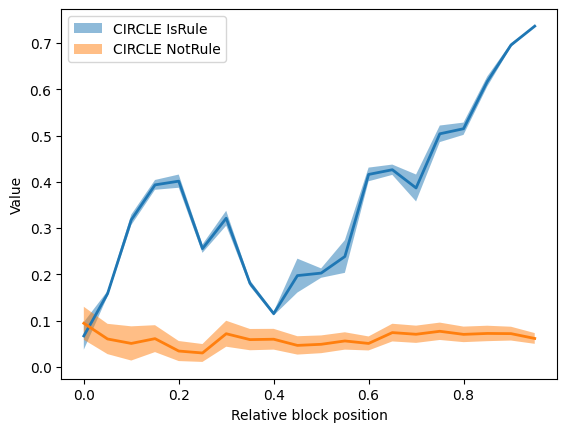

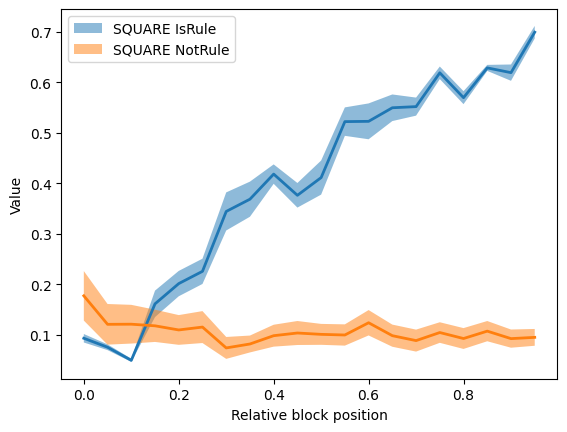

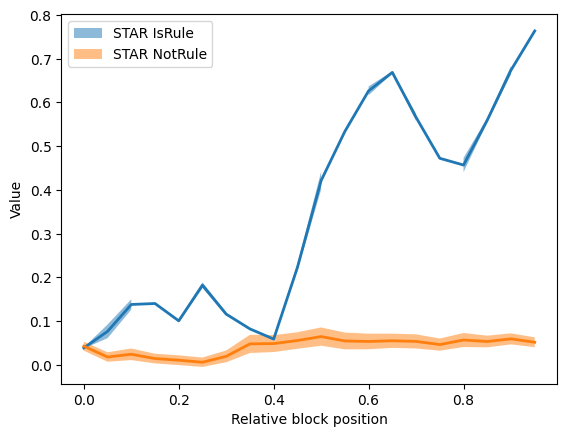

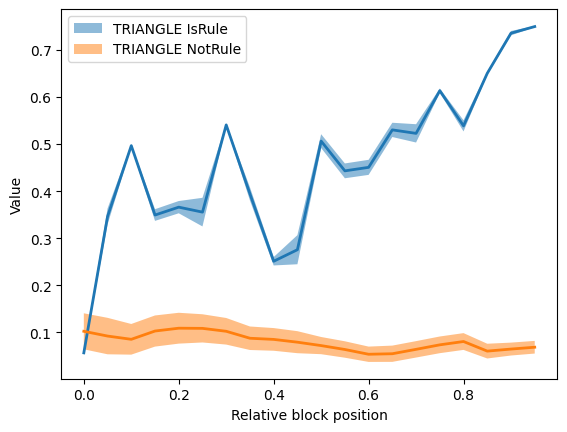

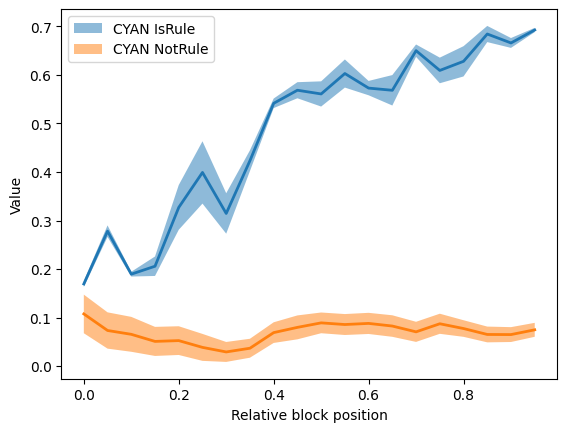

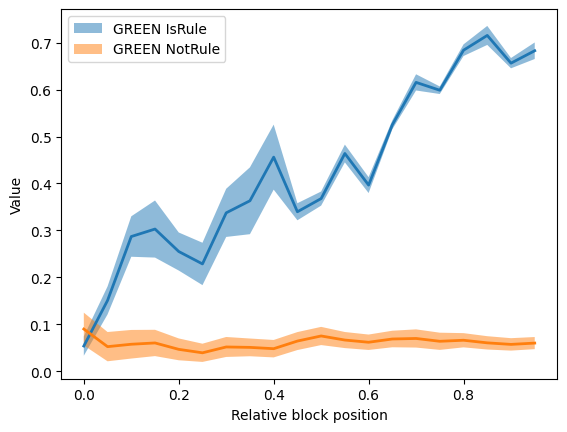

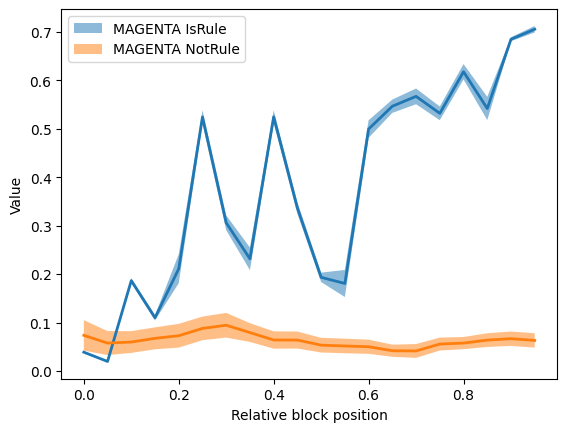

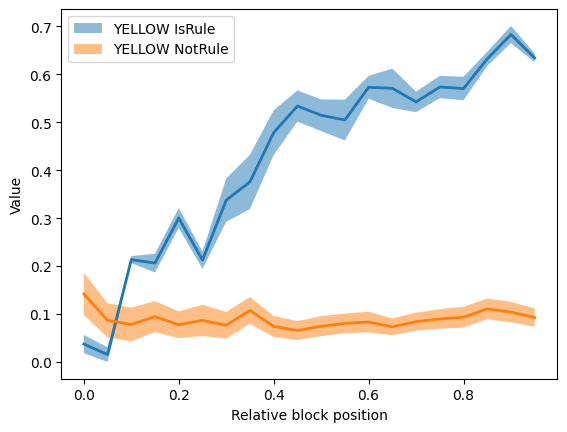

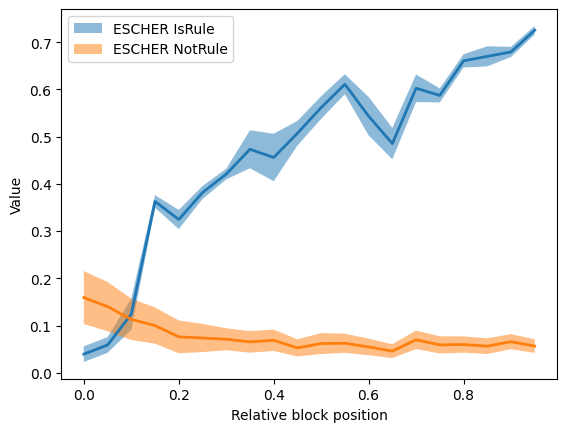

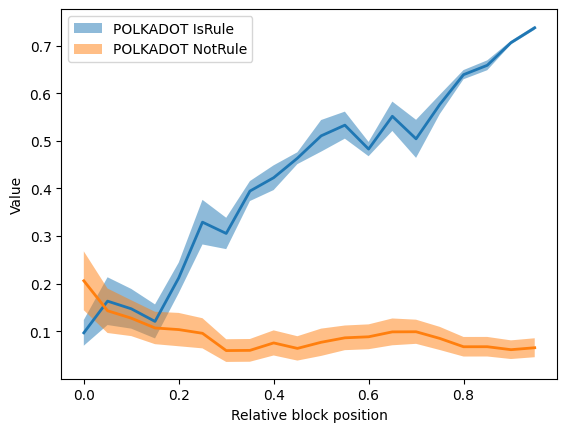

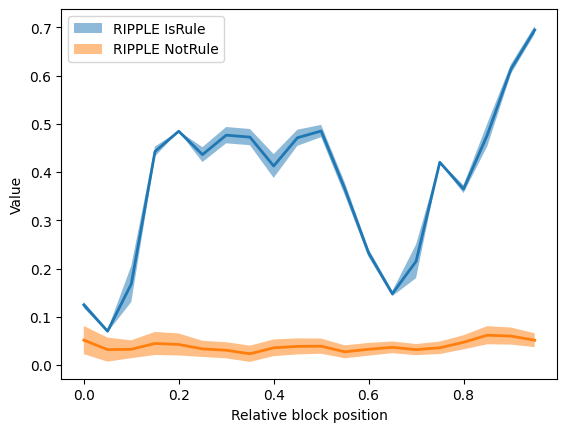

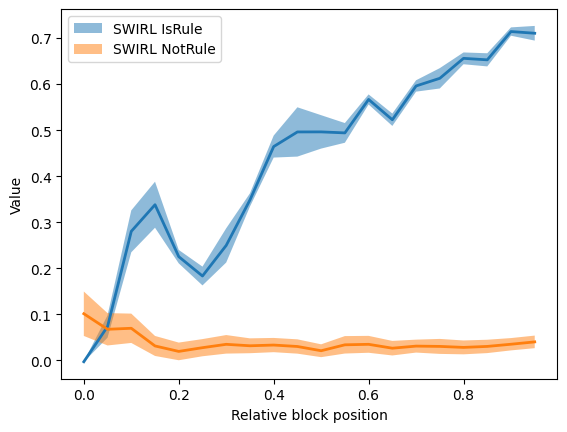

In [7]:
def plot_mean_sterrs(beh, ax, feat, label, num_bins):
    means = beh.groupby("BlockPositionBin")[feat + "Value"].mean()
    stds = beh.groupby("BlockPositionBin")[feat + "Value"].std()
    bin_size = 1 / num_bins
    time_bins = np.arange(0, 1, bin_size)
    mean_line, = ax.plot(time_bins, means, linewidth=2)
    sterr = stds / np.sqrt(len(stds))

    std_line = ax.fill_between(time_bins, means - sterr, means + sterr, alpha=0.5, label=label)
    ax.set_xlabel("Relative block position")
    ax.set_ylabel("Value")
    ax.legend()

value_beh_block = behavioral_utils.get_relative_block_position(value_beh, 20)
for feat in FEATURES:
    feat_matches = value_beh_block[value_beh_block.CurrentRule == feat]
    feat_not_matches = value_beh_block[value_beh_block.CurrentRule != feat]

    # fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    fig, ax = plt.subplots()
    plot_mean_sterrs(feat_matches, ax, feat, f"{feat} IsRule", 20)
    plot_mean_sterrs(feat_not_matches, ax, feat, f"{feat} NotRule", 20)





### Test code

In [13]:
import utils.io_utils as io_utils
sess_name = 20180802
beh, frs = io_utils.load_rpe_sess_beh_and_frs(sess_name, beh_path=SESS_BEHAVIOR_PATH)
beh = beh.reset_index()
# get the values
# beh = behavioral_utils.get_feature_values_per_session(sess_name, beh)
# beh = beh.set_index(["TrialNumber"])

In [14]:
beh_model_path = f"/data/082023_Feat_RLDE_HV/sess-{session}_hv.csv"
model_vals = pd.read_csv(beh_model_path)
renames = {}
for i, feat_name in enumerate(FEATURES):
    renames[f"feat_{i}"] = feat_name
model_vals = model_vals.rename(columns=renames)
valid_beh_vals = pd.merge(beh, model_vals, left_on="TrialNumber", right_on="trial", how="inner")
# check 
# assert(len(valid_beh_vals) == len(beh))
# def get_highest_val_feat(row):
#     color = row["Color"]
#     shape = row["Shape"]
#     pattern = row["Pattern"]
#     vals = {color: row[color], shape: row[shape], pattern: row[pattern]}
#     max_feat = max(zip(vals.values(), vals.keys()))[1]
#     row["MaxFeat"] = max_feat
#     return row
# valid_beh_max = valid_beh_vals.apply(get_highest_val_feat, axis=1)

In [ ]:
valid_beh_vals